# Autoencoder - Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import sys
sys.path.append('../../')
from utils.metrics import calculate_anomaly_metrics, format_results

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

2025-11-25 16:47:53.704795: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 16:47:54.139978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 16:47:55.696953: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# 1. CARGAR DATOS
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

feature_cols = [
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21'
]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Features: {len(feature_cols)}")

Train shape: (61249, 27)
Test shape: (41214, 26)
Features: 14


In [3]:
# 3. CREAR BASELINE (30% primeros ciclos)
def get_baseline(df, pct=0.3):
    baseline_list = []
    for unit in df['unit_id'].unique():
        unit_data = df[df['unit_id'] == unit]
        cutoff = unit_data['time_cycles'].max() * pct
        baseline_list.append(unit_data[unit_data['time_cycles'] <= cutoff])
    return pd.concat(baseline_list)

baseline = get_baseline(train)
X_baseline = baseline[feature_cols].values

# 4. NORMALIZACIÓN
scaler = StandardScaler()
X_baseline_scaled = scaler.fit_transform(X_baseline)

print(f"Baseline samples: {len(X_baseline_scaled)}")
print(f"Input dimension: {X_baseline_scaled.shape[1]}")

Baseline samples: 18273
Input dimension: 14


In [4]:
# 5. ARQUITECTURA AUTOENCODER
input_dim = X_baseline_scaled.shape[1]
encoding_dim = 8  # Dimensión del espacio latente

# Encoder
encoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim, activation='relu', name='encoding')
], name='encoder')

# Decoder
decoder = keras.Sequential([
    layers.Input(shape=(encoding_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(input_dim, activation='linear')
], name='decoder')

# Autoencoder completo
autoencoder = keras.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

autoencoder.summary()

2025-11-25 16:47:56.331876: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 8)              │         1,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 14)             │         1,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,294 (8.96 KB)

 Trainable params: 2,294 (8.96 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 6. ENTRENAR EN BASELINE
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_baseline_scaled, X_baseline_scaled,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6811 - val_loss: 0.0991
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1823 - val_loss: 0.0567
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1302 - val_loss: 0.0434
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1045 - val_loss: 0.0485
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0899 - val_loss: 0.0410
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0792 - val_loss: 0.0369
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0720 - val_loss: 0.0369
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0655 - val_loss: 0.0346
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0623 - val_loss: 0.0458
Epoch 10/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0582 - val_loss: 0.0379
Epoch 11/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0562 - val_loss: 0.0317
Epoch 12/100
115/115 ━━━━━━━━━━━━━━━━━━━━

In [6]:
# 7. CALCULAR ERROR EN BASELINE Y DEFINIR UMBRAL
X_baseline_reconstructed = autoencoder.predict(X_baseline_scaled)
baseline_errors = np.mean((X_baseline_scaled - X_baseline_reconstructed)**2, axis=1)

# Umbral: percentil 99 del baseline
threshold = np.percentile(baseline_errors, 99)
print(f"Umbral (p99): {threshold:.6f}")
print(f"Error medio baseline: {baseline_errors.mean():.6f}")
print(f"Error std baseline: {baseline_errors.std():.6f}")

572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
Umbral (p99): 0.096157
Error medio baseline: 0.015672
Error std baseline: 0.030697


In [7]:
# 8. DETECTAR ANOMALÍAS EN TRAIN
X_train = train[feature_cols].values
X_train_scaled = scaler.transform(X_train)
X_train_reconstructed = autoencoder.predict(X_train_scaled)

# Error de reconstrucción
train['reconstruction_error'] = np.mean((X_train_scaled - X_train_reconstructed)**2, axis=1)
train['is_anomaly'] = (train['reconstruction_error'] > threshold).astype(int)

# 9. MÉTRICAS
metrics = calculate_anomaly_metrics(train)
metrics['method'] = 'Autoencoder'
metrics['dataset'] = 'FD001'
format_results(metrics)

1915/1915 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step
📊 Autoencoder - FD001
Cobertura: 100.0% (249/249 unidades)
RUL promedio 1ª detección: 126.1 ciclos
Detección al 47.6% del ciclo
Detecciones tempranas (RUL>50): 227
Falsos positivos (RUL>150): 29.3%
% anomalías totales: 6.5%


/tmp/ipykernel_115212/118179267.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anomaly_rate = train.groupby('rul_bin')['is_anomaly'].mean() * 100


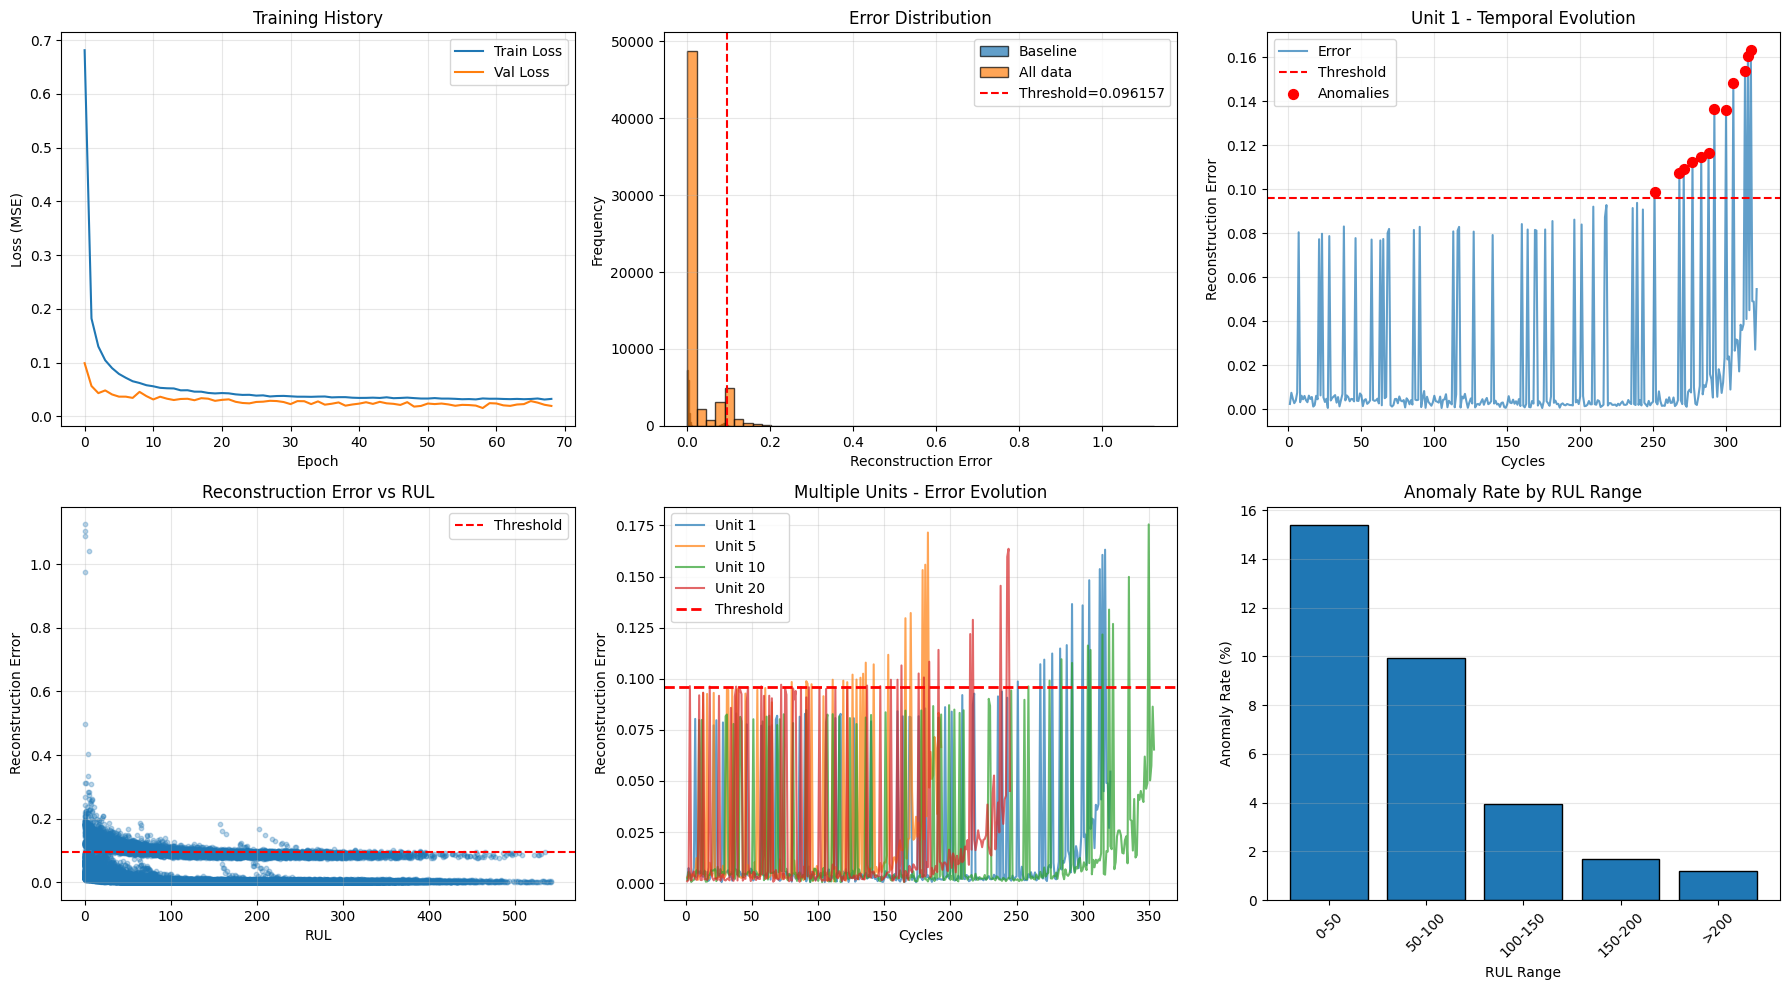

In [8]:
# 10. VISUALIZACIÓN
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# a) Historia del entrenamiento
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training History')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# b) Distribución de errores
axes[0, 1].hist(baseline_errors, bins=50, alpha=0.7, label='Baseline', edgecolor='black')
axes[0, 1].hist(train['reconstruction_error'], bins=50, alpha=0.7, label='All data', edgecolor='black')
axes[0, 1].axvline(threshold, color='r', linestyle='--', label=f'Threshold={threshold:.6f}')
axes[0, 1].set_xlabel('Reconstruction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Error Distribution')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# c) Evolución temporal ejemplo (unidad 1)
unit_1 = train[train['unit_id'] == 1]
axes[0, 2].plot(unit_1['time_cycles'], unit_1['reconstruction_error'], label='Error', alpha=0.7)
axes[0, 2].axhline(threshold, color='r', linestyle='--', label='Threshold')
axes[0, 2].scatter(unit_1[unit_1['is_anomaly']==1]['time_cycles'], 
                   unit_1[unit_1['is_anomaly']==1]['reconstruction_error'], 
                   color='red', s=50, label='Anomalies', zorder=3)
axes[0, 2].set_xlabel('Cycles')
axes[0, 2].set_ylabel('Reconstruction Error')
axes[0, 2].set_title('Unit 1 - Temporal Evolution')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# d) Error vs RUL
axes[1, 0].scatter(train['RUL'], train['reconstruction_error'], alpha=0.3, s=10)
axes[1, 0].axhline(threshold, color='r', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('RUL')
axes[1, 0].set_ylabel('Reconstruction Error')
axes[1, 0].set_title('Reconstruction Error vs RUL')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# e) Evolución temporal para múltiples unidades
for unit_id in [1, 5, 10, 20]:
    unit_data = train[train['unit_id'] == unit_id]
    axes[1, 1].plot(unit_data['time_cycles'], unit_data['reconstruction_error'], 
                    label=f'Unit {unit_id}', alpha=0.7)
axes[1, 1].axhline(threshold, color='r', linestyle='--', label='Threshold', linewidth=2)
axes[1, 1].set_xlabel('Cycles')
axes[1, 1].set_ylabel('Reconstruction Error')
axes[1, 1].set_title('Multiple Units - Error Evolution')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# f) Tasa de anomalías por RUL bin
train['rul_bin'] = pd.cut(train['RUL'], bins=[0, 50, 100, 150, 200, 300], 
                          labels=['0-50', '50-100', '100-150', '150-200', '>200'])
anomaly_rate = train.groupby('rul_bin')['is_anomaly'].mean() * 100
axes[1, 2].bar(range(len(anomaly_rate)), anomaly_rate.values, edgecolor='black')
axes[1, 2].set_xticks(range(len(anomaly_rate)))
axes[1, 2].set_xticklabels(anomaly_rate.index, rotation=45)
axes[1, 2].set_xlabel('RUL Range')
axes[1, 2].set_ylabel('Anomaly Rate (%)')
axes[1, 2].set_title('Anomaly Rate by RUL Range')
axes[1, 2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/autoencoder_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# 11. GUARDAR RESULTADOS
output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

# Anomalías detectadas
train[['unit_id', 'time_cycles', 'RUL', 'reconstruction_error', 'is_anomaly']].to_csv(
    output_dir / 'autoencoder_anomalies.csv', index=False
)

# Métricas
pd.DataFrame([metrics]).to_csv(
    output_dir / 'autoencoder_metrics.csv', index=False
)

# Guardar modelo
autoencoder.save(output_dir / 'autoencoder_model.keras')

print("\n✅ Resultados guardados en ./outputs/")
print(f"   - autoencoder_anomalies.csv")
print(f"   - autoencoder_metrics.csv")
print(f"   - autoencoder_analysis.png")
print(f"   - autoencoder_model.keras")


✅ Resultados guardados en ./outputs/
   - autoencoder_anomalies.csv
   - autoencoder_metrics.csv
   - autoencoder_analysis.png
   - autoencoder_model.keras
